# Stock Market Prediction Using Numerical and Textual Analysis

### Name : Mohamed Ahmed Abd El mgeed

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Loading data

In [2]:
stock_price = pd.read_csv('AAPL.csv')
stock_headlines = pd.read_csv('india-news-headlines.csv')

In [3]:
# shape of stock_price data 
stock_price.shape

(5724, 7)

In [4]:
# shape of stock_headlines data
stock_headlines.shape

(3650970, 3)

In [5]:
### first five Rows of stock_price data
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,0.936384,1.004464,0.907924,0.999442,0.853356,535796800
1,2000-01-04,0.966518,0.987723,0.903460,0.915179,0.781409,512377600
2,2000-01-05,0.926339,0.987165,0.919643,0.928571,0.792843,778321600
3,2000-01-06,0.947545,0.955357,0.848214,0.848214,0.724232,767972800
4,2000-01-07,0.861607,0.901786,0.852679,0.888393,0.758538,460734400


In [6]:
### info about stock_price data
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5724 entries, 0 to 5723
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5724 non-null   object 
 1   Open       5724 non-null   float64
 2   High       5724 non-null   float64
 3   Low        5724 non-null   float64
 4   Close      5724 non-null   float64
 5   Adj Close  5724 non-null   float64
 6   Volume     5724 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 313.2+ KB


### preprocessing

In [7]:
### convert Data type of date to datetime64
stock_price['Date'] = pd.to_datetime(stock_price['Date'], format='%Y-%m-%d', errors='coerce')
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,0.936384,1.004464,0.907924,0.999442,0.853356,535796800
1,2000-01-04,0.966518,0.987723,0.903460,0.915179,0.781409,512377600
2,2000-01-05,0.926339,0.987165,0.919643,0.928571,0.792843,778321600
3,2000-01-06,0.947545,0.955357,0.848214,0.848214,0.724232,767972800
4,2000-01-07,0.861607,0.901786,0.852679,0.888393,0.758538,460734400


In [8]:
stock_price.set_index('Date', inplace= True)

# sorting the data according to Date
stock_price = stock_price.sort_index(ascending=True, axis=0)

In [9]:
### counting duplicates
stock_price.duplicated().sum()

0

Text(0, 0.5, 'Close Price (INR)')

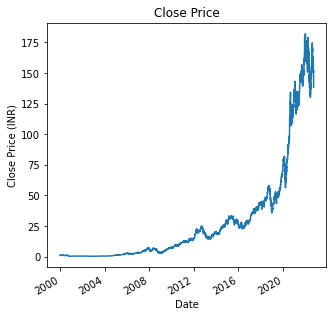

In [10]:
### Trend of price
plt.figure(figsize=(5,5))
stock_price['Close'].plot()

plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')

<AxesSubplot:xlabel='Date'>

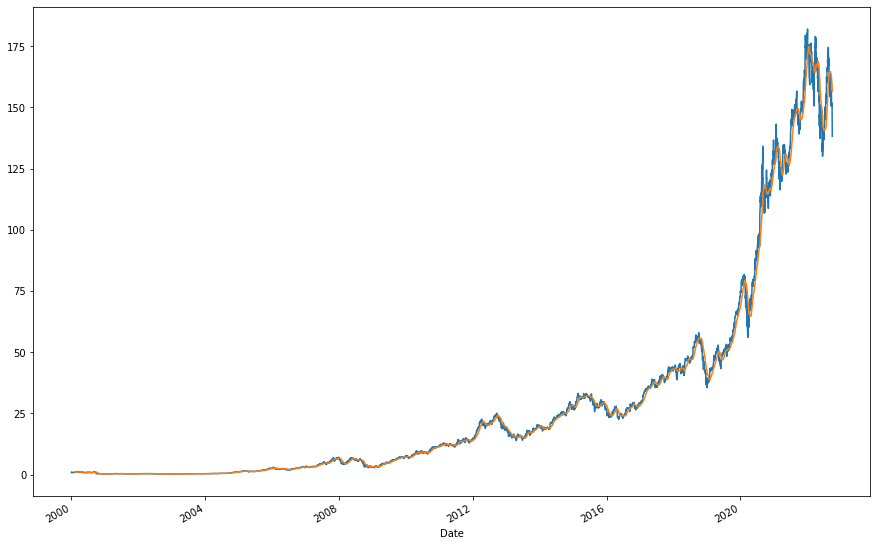

In [11]:
# setting figure size
plt.figure(figsize=(15,10))

# plotting the close price and a 30-day rolling mean of close price
stock_price['Close'].plot()
stock_price.rolling(window=30).mean()['Close'].plot()

In [12]:
### first five rows of data 
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [13]:
### shape of data
stock_headlines.shape

(3650970, 3)

In [14]:
### counting duplicates
stock_headlines.duplicated().sum()

24860

In [15]:
### drop duplicates

stock_headlines.drop_duplicates(inplace=True)

In [16]:
stock_headlines.isna().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

In [17]:
# converting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns 
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to Date
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting Date as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the Date
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


In [18]:
from textblob import TextBlob
polarity = []
subjectivity = []
for idx, row in stock_headlines.iterrows():
    polarity.append(TextBlob(row['headline_text']).sentiment[0])
    subjectivity.append(TextBlob(row['headline_text']).sentiment[1])
    
stock_headlines['polarity'] = polarity
stock_headlines['subjectivity'] = subjectivity
stock_headlines    

,headline_text,polarity,subjectivity
publish_date,,,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.148485,0.240909
2001-01-03,"Powerless north India gropes in the dark,Think...",0.108333,0.458333
2001-01-04,The string that pulled Stephen Hawking to Indi...,0.115404,0.512342
2001-01-05,Light combat craft takes India into club class...,0.257045,0.462652
2001-01-06,Light combat craft takes India into club class...,0.219481,0.464935
...,...,...,...
2022-03-27,Playing a dead man in Body God meant sitting i...,0.031550,0.371446
2022-03-28,As fashion becomes democratic; demand for styl...,0.053177,0.383737
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...,0.086287,0.401912


In [19]:
# concatenation of the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)
stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Open,High,Low,Close,Adj Close,Volume,headline_text,polarity,subjectivity
2001-01-02,0.265625,0.272321,0.260045,0.265625,0.226799,452312000.0,Status quo will not be disturbed at Ayodhya; s...,0.148485,0.240909
2001-01-03,0.258929,0.297991,0.257813,0.292411,0.249670,817073600.0,"Powerless north India gropes in the dark,Think...",0.108333,0.458333
2001-01-04,0.323940,0.330357,0.300223,0.304688,0.260152,739396000.0,The string that pulled Stephen Hawking to Indi...,0.115404,0.512342
2001-01-05,0.302455,0.310268,0.286830,0.292411,0.249670,412356000.0,Light combat craft takes India into club class...,0.257045,0.462652
2001-01-08,0.302455,0.303292,0.284598,0.295759,0.252528,373699200.0,"Sangh Parivar; Babri panel up the ante,Frontru...",0.013447,0.316351
...,...,...,...,...,...,...,...,...,...
2022-03-25,173.880005,175.279999,172.750000,174.720001,174.221664,80546200.0,Speeding up; shortcuts and tackling unruly cus...,0.003142,0.374713
2022-03-28,172.169998,175.729996,172.000000,175.600006,175.099167,90371900.0,As fashion becomes democratic; demand for styl...,0.053177,0.383737
2022-03-29,176.690002,179.009995,176.339996,178.960007,178.449570,100589400.0,Bobby Deol: Like my dad; I hope to be working ...,0.086287,0.401912
2022-03-30,178.550003,179.610001,176.699997,177.770004,177.262970,92633200.0,"I will not give in to trends: Dossmode,The tim...",0.037741,0.354163


### Splitting data

In [20]:
x=stock_data[['Open', 'High',  'Volume', 'polarity', 'subjectivity']]
y=stock_data[['Close']]

In [21]:
#Train-Test split
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.15,shuffle=False)

### Modelling

In [22]:
model =LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_tr = model.predict(x_train)
print(f'Training RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_tr))}')
print(f'Training MAE: {mean_absolute_error(y_train, y_pred_tr)}')
print(f'Training R2: {r2_score(y_train, y_pred_tr)}')
print('++++++')
print(f'Testing RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'Testing MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Testing R2: {r2_score(y_test, y_pred)}')
print('-'*50)

Training RMSE: 0.16862072808083398
Training MAE: 0.09506744799957792
Training R2: 0.9998577682919938
++++++
Testing RMSE: 1.2254690116412381
Testing MAE: 0.7920143906155299
Testing R2: 0.9991462556610635
--------------------------------------------------


In [23]:
b=y_test
a = pd.DataFrame(y_pred,columns=["Predicted value"],index=b.index)
result = pd.concat([b, a], axis=1)
result

,Close,Predicted value
2019-02-01,41.630001,41.902251
2019-02-04,42.812500,42.631566
2019-02-05,43.544998,43.410551
2019-02-06,43.560001,43.490928
2019-02-07,42.735001,43.109758
...,...,...
2022-03-25,174.720001,173.634361
2022-03-28,175.600006,174.378928
2022-03-29,178.960007,177.458345
2022-03-30,177.770004,177.877370


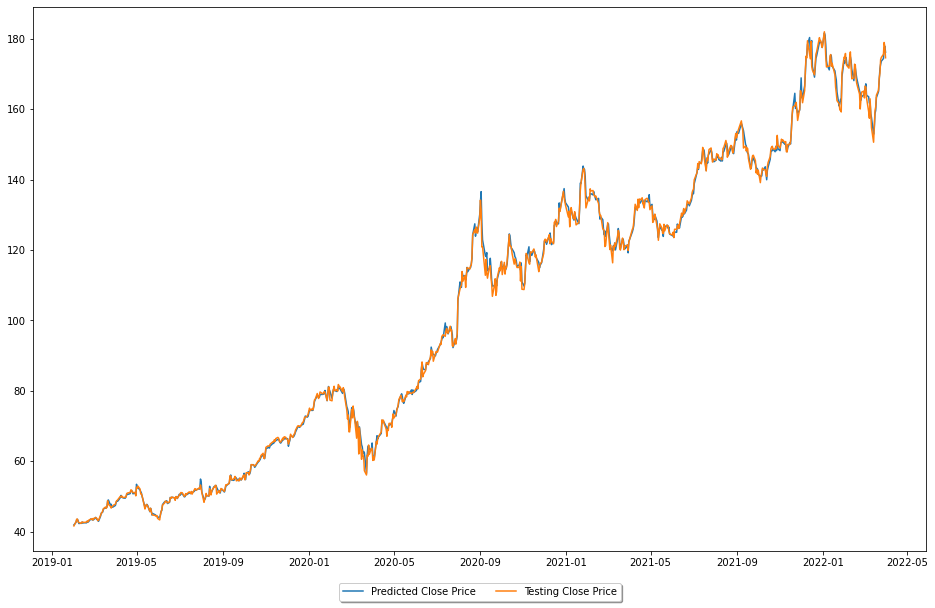

In [24]:
# plotting
plt.figure(figsize=(16,10))
plt.plot(a, label="Predicted Close Price")
plt.plot(b, label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()